In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import pickle
import pandas as pd
import os
from spot_pattern_generator_functions import SpotGenerator
from skimage.io import imread, imsave
from skimage.measure import regionprops, label
import seaborn as sns

In [2]:
scr_ncaph2_df = pd.read_pickle('/data/krishnendu/ripley_paper/8cell_lines/scr_ncaph2_latest_results/light_scr_ncaph2.pkl')

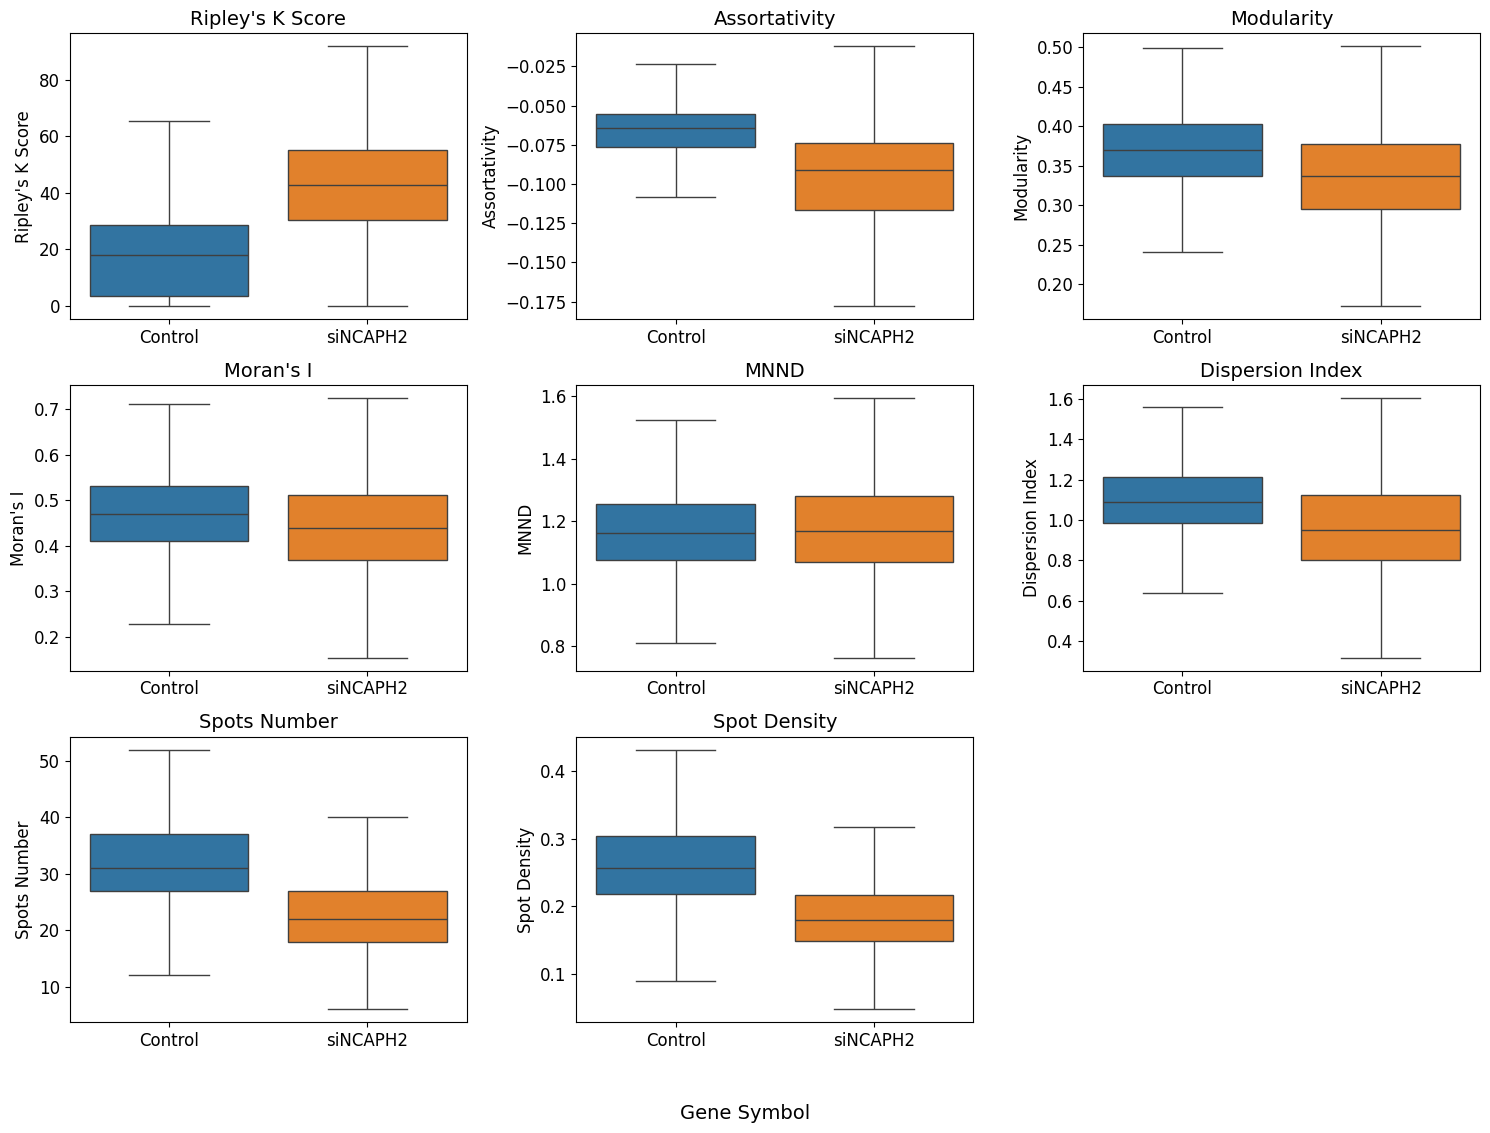

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
scr_ncaph2_df.rename(columns={'M0_mean_nearest_neighbor_distance': 'M0_MNND'}, inplace=True)
scr_ncaph2_df['gene_symbol'] = scr_ncaph2_df['gene_symbol'].replace({
    'NCAPH2': 'siNCAPH2',
    'siScrambled': 'Control'
})

# Assuming scr_ncaph2 DataFrame is already loaded and contains the necessary columns
scr_ncaph2_df['spot_density'] = scr_ncaph2_df.apply(lambda x: x.spots_number/x.area, axis=1)
# Define the columns to plot
columns_to_plot = ['M0_ripley_k_score', 'M0_assortativity', 'M0_modularity', 'M0_morans_i', 'M0_MNND', 'M0_dispersion_index', 'spots_number', 'spot_density']

def format_label(text):
    if text == 'M0_MNND':
        return 'MNND'
    if text == 'M0_ripley_k_score':
        return r"Ripley's K Score"
    if  (text=="M0_morans_i"):
        return r"Moran's I"
    return ' '.join([word.capitalize() for word in text.replace('M0', ' ').replace('_', ' ').split()])

# Reverse the order of gene_symbol categories
scr_ncaph2_df['gene_symbol'] = pd.Categorical(
    scr_ncaph2_df['gene_symbol'], 
    categories=sorted(scr_ncaph2_df['gene_symbol'].unique()),
    ordered=True
)

# Create the box plots for each column
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Loop through each column to create subplots
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    sns.boxplot(
        x='gene_symbol', y=column, data=scr_ncaph2_df, ax=ax, showfliers=False, 
        hue='gene_symbol', palette=['#1f77b4', '#ff7f0e'], dodge=False
    )
    ax.set_title(format_label(column), fontsize=14)  # Increase title font size
    ax.set_ylabel(format_label(column), fontsize=12)
    ax.set_xlabel('')  # Suppress individual x-axis labels
    
    # Increase the font size of tick labels
    ax.tick_params(axis='x', labelsize=12)  # x-axis tick labels
    ax.tick_params(axis='y', labelsize=12)  # y-axis tick labels

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set a shared xlabel for the entire figure
fig.supxlabel('Gene Symbol', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


/tmp/ipykernel_126521/2385049755.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


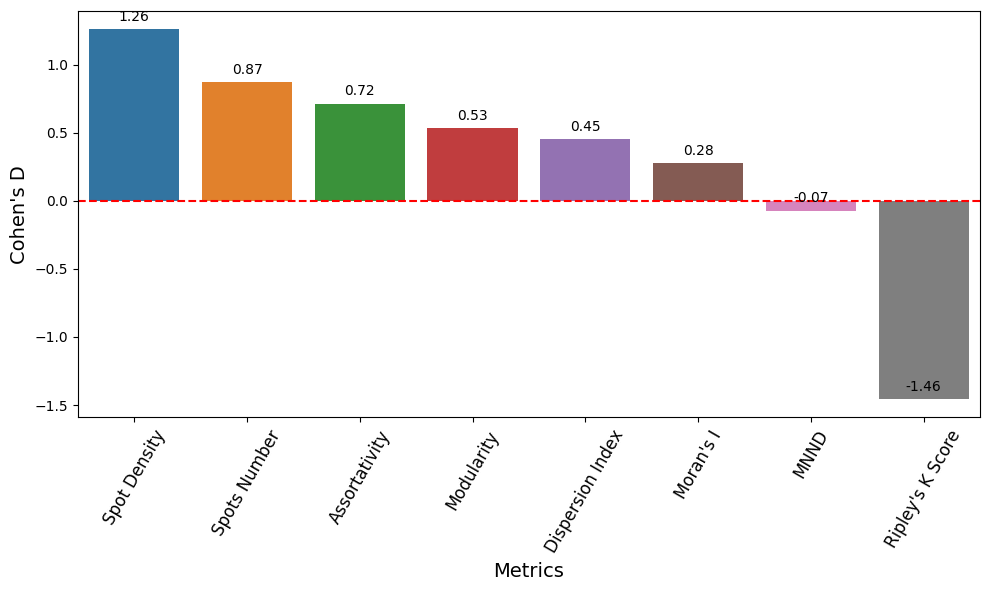

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Suppress specific FutureWarning and UserWarning messages
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')

# Define the columns to plot
columns_to_plot = ['M0_ripley_k_score', 'M0_assortativity', 'M0_modularity', 'M0_morans_i', 'M0_MNND', 'M0_dispersion_index', 'spots_number', 'spot_density']

def format_label(text):
    if text == 'M0_MNND':
        return 'MNND'
    if text == 'M0_ripley_k_score':
        return r"Ripley's K Score"
    if  (text=="M0_morans_i"):
        return r"Moran's I"
    return ' '.join([word.capitalize() for word in text.replace('M0', ' ').replace('_', ' ').split()])


# Separate the data into two groups based on gene_symbol
group1 = scr_ncaph2_df[scr_ncaph2_df['gene_symbol'] == scr_ncaph2_df['gene_symbol'].unique()[0]]
group2 = scr_ncaph2_df[scr_ncaph2_df['gene_symbol'] == scr_ncaph2_df['gene_symbol'].unique()[1]]

def cohen_d(group1, group2):
    """Calculate Cohen's d."""
    diff_mean = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff_mean / pooled_std

# Calculate Cohen's d for each metric
effect_sizes = {}
for column in columns_to_plot:
    d = cohen_d(group1[column], group2[column])
    effect_sizes[column] = d

# Convert effect sizes to a DataFrame for plotting
effect_sizes_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['Cohen_d'])

# Sort the effect sizes from highest to lowest
effect_sizes_df = effect_sizes_df.sort_values(by='Cohen_d', ascending=False)


# Apply formatting to the index of the effect_sizes_df for display
effect_sizes_df.index = [format_label(col) for col in effect_sizes_df.index]

# Plot the effect sizes
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=effect_sizes_df.index, 
    y='Cohen_d', 
    data=effect_sizes_df.reset_index(), 
    palette=sns.color_palette("tab10")[:len(effect_sizes_df)]
)
plt.xticks(rotation=60, fontsize=12)
# plt.title("Comparison of Metrics for Centromere Clustering Using Cohen’s D", fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel("Cohen's D", fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()



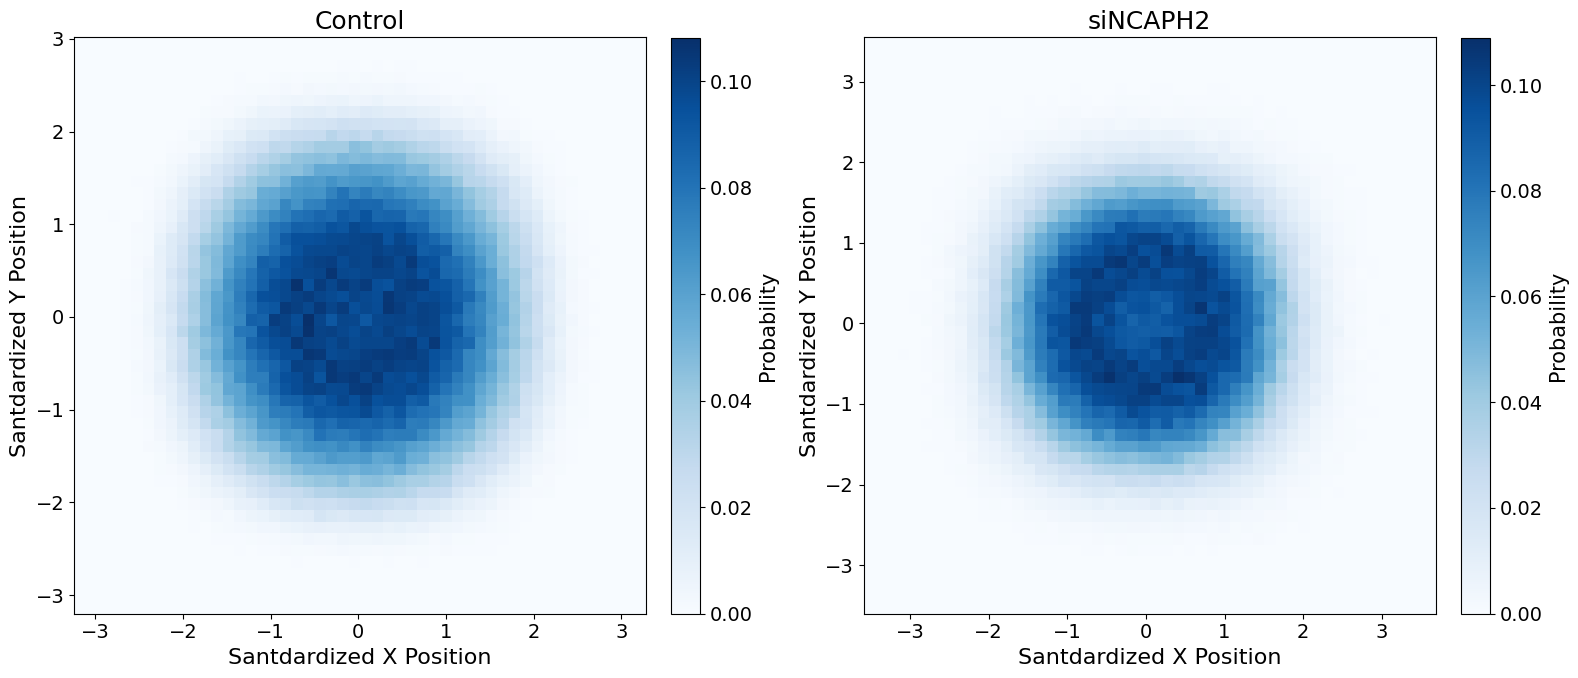

In [138]:
import numpy as np
import matplotlib.pyplot as plt
scr_ncaph2_df['gene_symbol'] = scr_ncaph2_df['gene_symbol'].replace({
    'NCAPH2': 'siNCAPH2',
    'scrambled': 'siScrambled'
})

# Increase the global font size for all elements
plt.rcParams.update({'font.size': 14})  # Set font size to 14, adjust as needed

# Assuming your dataframe is called 'scr_ncaph2_df'
gene_symbols = scr_ncaph2_df['gene_symbol'].unique()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for i, cell in enumerate(gene_symbols):
    # Select the current axis for plotting
    ax = axes[i]
    
    # Filter data for the current cell type
    scr_ncaph2_df1 = scr_ncaph2_df.loc[scr_ncaph2_df['gene_symbol'] == cell]
    data = np.vstack(scr_ncaph2_df1['nuc_centered_spots_std'].values)
    
    # Split the data into x and y coordinates
    x = data[:, 0]
    y = data[:, 1]

    # Remove NaN values from the x and y arrays
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    # Create a 2D histogram
    h = ax.hist2d(x, y, bins=50, cmap='Blues', density=True)


    cb = fig.colorbar(h[3], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label('Probability', fontsize=15)  # Increase font size of the colorbar label

    # Set labels and title with custom font sizes
    ax.set_xlabel('Santdardized X Position', fontsize=16)  # Increase font size for x label
    ax.set_ylabel('Santdardized Y Position', fontsize=16)  # Increase font size for y label
    if cell=='siScrambled':
        title_='Control'
    else:
        title_=cell
    ax.set_title(f'{title_}', fontsize=18)  # Increase font size for title

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


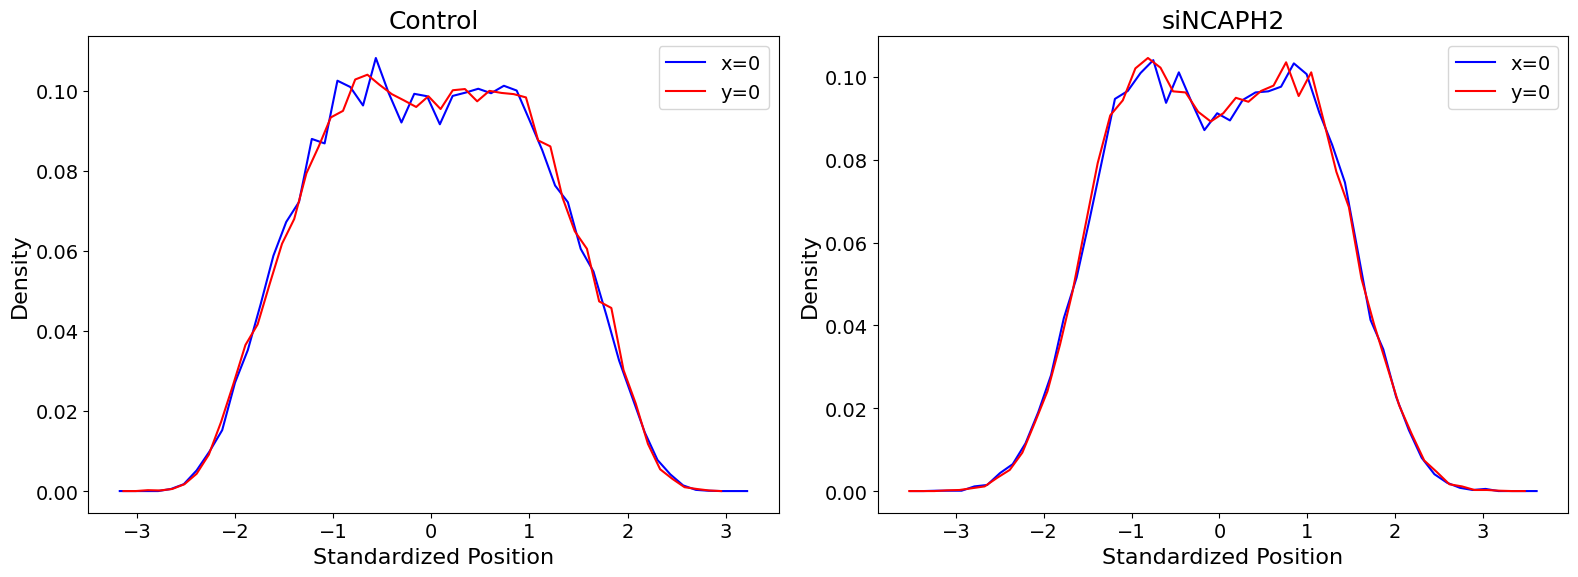

In [123]:
import numpy as np
import matplotlib.pyplot as plt
scr_ncaph2_df['gene_symbol'] = scr_ncaph2_df['gene_symbol'].replace({
    'NCAPH2': 'siNCAPH2',
    'scrambled': 'siScrambled'
})
# Assuming your dataframe is called 'scr_real_spots'
gene_symbols = scr_ncaph2_df['gene_symbol'].unique()

# Create a figure with a 2 by 4 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for i, cell in enumerate(gene_symbols):
    # Select the current axis for plotting
    ax = axes[i]
    
    # Filter data for the current cell type
    scr_real_spots1 = scr_ncaph2_df.loc[scr_ncaph2_df['gene_symbol'] == cell]
    data = np.vstack(scr_real_spots1['nuc_centered_spots_std'].values)
    
    # Split the data into x and y coordinates
    x = data[:, 0]
    y = data[:, 1]

    # Create a 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=50, density=True)
    
    # Get the centers of the bins
    x_bin_centers = (xedges[:-1] + xedges[1:]) / 2
    y_bin_centers = (yedges[:-1] + yedges[1:]) / 2
    
    # Extract the line plot for x=0 and y=0
    x_center_idx = np.abs(x_bin_centers).argmin()
    y_center_idx = np.abs(y_bin_centers).argmin()
    
    x_line = h[:, y_center_idx]  # Line for x = 0
    y_line = h[x_center_idx, :]  # Line for y = 0
    
    # Plot the line plots on the current axis
    ax.plot(x_bin_centers, x_line, 'b-', label='x=0')  # Blue line for x = 0
    ax.plot(y_bin_centers, y_line, 'r-', label='y=0')  # Red line for y = 0
    
    # Set labels and title
    ax.set_xlabel('Standardized Position', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    if cell=='siScrambled':
        title_='Control'
    else:
        title_=cell
    ax.set_title(f'{title_}', fontsize=18)  # Increase font size for title
    
    # Add legend
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [133]:
scr_ncaph2_df.gene_symbol.unique()[0]

'siScrambled'

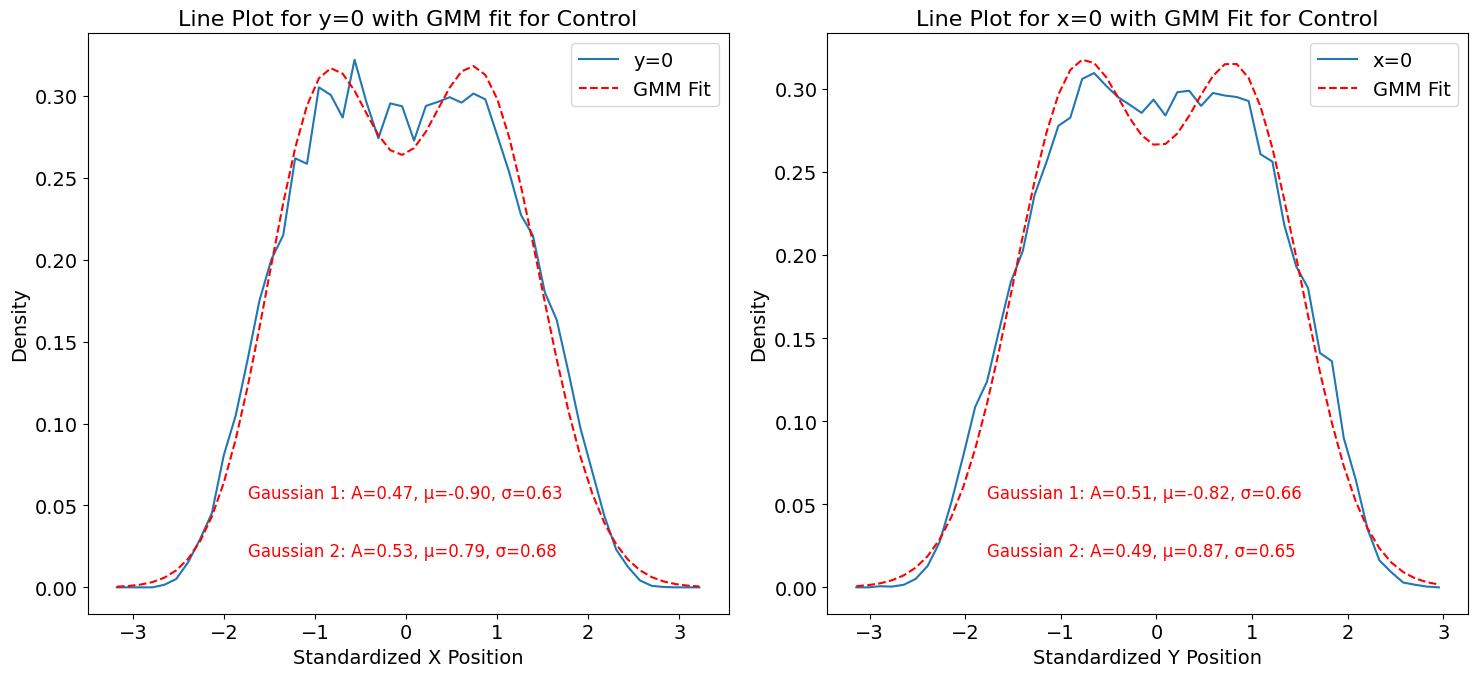

In [136]:
from sklearn.mixture import GaussianMixture
ind=0
scr_real_spots1 = scr_ncaph2_df.loc[scr_ncaph2_df['gene_symbol'] == scr_ncaph2_df.gene_symbol.unique()[ind]]
data = np.vstack(scr_real_spots1['nuc_centered_spots_std'].values)

# Split the data into x and y coordinatesa
x = data[:, 0]
y = data[:, 1]
# Assume 'x_data' and 'y_data' are your original data arrays

# Step 1: Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(x, y, bins=50, density=True)

# Step 2: Calculate the bin centers
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Step 3: Extract slices where y=0 and x=0
x_slice_index = np.argmin(np.abs(y_bin_centers))  # Closest bin to y=0
y_slice_index = np.argmin(np.abs(x_bin_centers))  # Closest bin to x=0

x_slice = hist[:, x_slice_index]  # Values along the y=0 line
y_slice = hist[y_slice_index, :]  # Values along the x=0 line

# Step 4: Normalize the slices
x_slice_normalized = x_slice / np.trapz(x_slice, x_bin_centers)
y_slice_normalized = y_slice / np.trapz(y_slice, y_bin_centers)

# Now you have x_bin_centers, y_bin_centers, x_slice_normalized, and y_slice_normalized

# Reshape the data for GMM by repeating the data points according to their normalized counts
x_data_expanded = np.repeat(x_bin_centers, np.round(x_slice_normalized * 1000).astype(int)).reshape(-1, 1)
y_data_expanded = np.repeat(y_bin_centers, np.round(y_slice_normalized * 1000).astype(int)).reshape(-1, 1)

# Fit GMM for x=0 slice
gmm_x = GaussianMixture(n_components=2).fit(x_data_expanded)
x_gmm_fit = np.exp(gmm_x.score_samples(x_bin_centers.reshape(-1, 1)))

# Fit GMM for y=0 slice
gmm_y = GaussianMixture(n_components=2).fit(y_data_expanded)
y_gmm_fit = np.exp(gmm_y.score_samples(y_bin_centers.reshape(-1, 1)))

# Normalize GMM fits so that area under the curve is 1
x_gmm_fit_normalized = x_gmm_fit / np.trapz(x_gmm_fit, x_bin_centers)
y_gmm_fit_normalized = y_gmm_fit / np.trapz(y_gmm_fit, y_bin_centers)

# Goodness-of-fit: Correlation Coefficient
x_corr_coef, _ = pearsonr(x_slice_normalized, x_gmm_fit_normalized)
y_corr_coef, _ = pearsonr(y_slice_normalized, y_gmm_fit_normalized)

# Extract means, standard deviations, and amplitudes of the fitted Gaussian components
x_means = gmm_x.means_.flatten()
x_stds = np.sqrt(gmm_x.covariances_).flatten()
x_amplitudes = gmm_x.weights_

y_means = gmm_y.means_.flatten()
y_stds = np.sqrt(gmm_y.covariances_).flatten()
y_amplitudes = gmm_y.weights_

# Plotting the line plots with GMM fits
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(x_bin_centers, x_slice_normalized, label='y=0')
plt.plot(x_bin_centers, x_gmm_fit_normalized, 'r--', label='GMM Fit')
plt.xlabel('Standardized X Position', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Line Plot for y=0 with GMM fit for Control', fontsize=16)
plt.grid(False)
plt.legend()

# Add text annotation for amplitude, mean, and std
for i, (amplitude, mean, std) in enumerate(zip(x_amplitudes, x_means, x_stds)):
    plt.text(0.25, 0.2 - 0.1 * i, f'Gaussian {i+1}: A={amplitude:.2f}, μ={mean:.2f}, σ={std:.2f}', 
             transform=plt.gca().transAxes, fontsize=12, color='red')

plt.subplot(1, 2, 2)
plt.plot(y_bin_centers, y_slice_normalized, label='x=0')
plt.plot(y_bin_centers, y_gmm_fit_normalized, 'r--', label='GMM Fit')
plt.xlabel('Standardized Y Position', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Line Plot for x=0 with GMM Fit for Control', fontsize=16)
plt.grid(False)
plt.legend()

# Add text annotation for amplitude, mean, and std
for i, (amplitude, mean, std) in enumerate(zip(y_amplitudes, y_means, y_stds)):
    plt.text(0.25, 0.2 - 0.1 * i, f'Gaussian {i+1}: A={amplitude:.2f}, μ={mean:.2f}, σ={std:.2f}', 
             transform=plt.gca().transAxes, fontsize=12, color='red')

plt.tight_layout()
plt.show()


In [134]:
scr_ncaph2_df.gene_symbol.unique()[1]

'siNCAPH2'

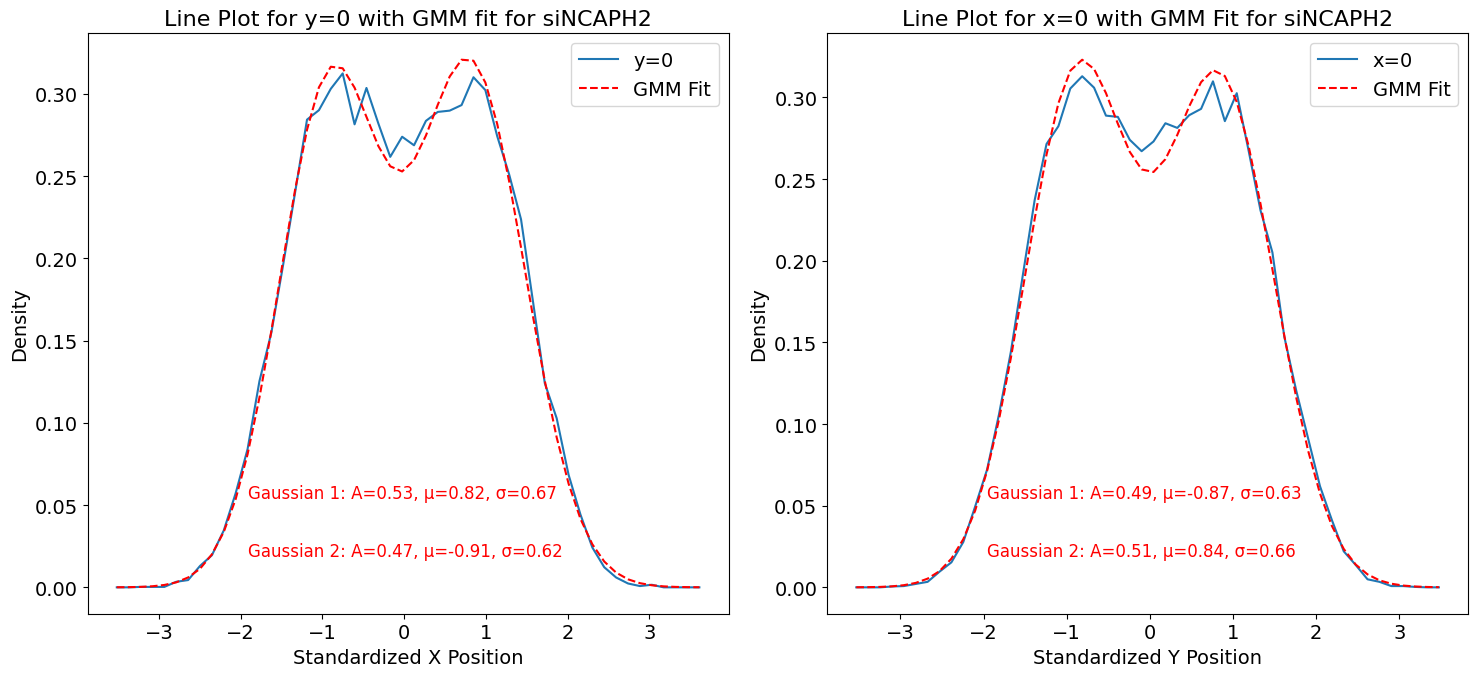

In [135]:
from sklearn.mixture import GaussianMixture
ind=1
scr_real_spots1 = scr_ncaph2_df.loc[scr_ncaph2_df['gene_symbol'] == scr_ncaph2_df.gene_symbol.unique()[ind]]
data = np.vstack(scr_real_spots1['nuc_centered_spots_std'].values)

# Split the data into x and y coordinatesa
x = data[:, 0]
y = data[:, 1]
# Assume 'x_data' and 'y_data' are your original data arrays

# Step 1: Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(x, y, bins=50, density=True)

# Step 2: Calculate the bin centers
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Step 3: Extract slices where y=0 and x=0
x_slice_index = np.argmin(np.abs(y_bin_centers))  # Closest bin to y=0
y_slice_index = np.argmin(np.abs(x_bin_centers))  # Closest bin to x=0

x_slice = hist[:, x_slice_index]  # Values along the y=0 line
y_slice = hist[y_slice_index, :]  # Values along the x=0 line

# Step 4: Normalize the slices
x_slice_normalized = x_slice / np.trapz(x_slice, x_bin_centers)
y_slice_normalized = y_slice / np.trapz(y_slice, y_bin_centers)

# Now you have x_bin_centers, y_bin_centers, x_slice_normalized, and y_slice_normalized

# Reshape the data for GMM by repeating the data points according to their normalized counts
x_data_expanded = np.repeat(x_bin_centers, np.round(x_slice_normalized * 1000).astype(int)).reshape(-1, 1)
y_data_expanded = np.repeat(y_bin_centers, np.round(y_slice_normalized * 1000).astype(int)).reshape(-1, 1)

# Fit GMM for x=0 slice
gmm_x = GaussianMixture(n_components=2).fit(x_data_expanded)
x_gmm_fit = np.exp(gmm_x.score_samples(x_bin_centers.reshape(-1, 1)))

# Fit GMM for y=0 slice
gmm_y = GaussianMixture(n_components=2).fit(y_data_expanded)
y_gmm_fit = np.exp(gmm_y.score_samples(y_bin_centers.reshape(-1, 1)))

# Normalize GMM fits so that area under the curve is 1
x_gmm_fit_normalized = x_gmm_fit / np.trapz(x_gmm_fit, x_bin_centers)
y_gmm_fit_normalized = y_gmm_fit / np.trapz(y_gmm_fit, y_bin_centers)

# Goodness-of-fit: Correlation Coefficient
x_corr_coef, _ = pearsonr(x_slice_normalized, x_gmm_fit_normalized)
y_corr_coef, _ = pearsonr(y_slice_normalized, y_gmm_fit_normalized)

# Extract means, standard deviations, and amplitudes of the fitted Gaussian components
x_means = gmm_x.means_.flatten()
x_stds = np.sqrt(gmm_x.covariances_).flatten()
x_amplitudes = gmm_x.weights_

y_means = gmm_y.means_.flatten()
y_stds = np.sqrt(gmm_y.covariances_).flatten()
y_amplitudes = gmm_y.weights_

# Plotting the line plots with GMM fits
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(x_bin_centers, x_slice_normalized, label='y=0')
plt.plot(x_bin_centers, x_gmm_fit_normalized, 'r--', label='GMM Fit')
plt.xlabel('Standardized X Position', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Line Plot for y=0 with GMM fit for siNCAPH2', fontsize=16)
plt.grid(False)
plt.legend()

# Add text annotation for amplitude, mean, and std
for i, (amplitude, mean, std) in enumerate(zip(x_amplitudes, x_means, x_stds)):
    plt.text(0.25, 0.2 - 0.1 * i, f'Gaussian {i+1}: A={amplitude:.2f}, μ={mean:.2f}, σ={std:.2f}', 
             transform=plt.gca().transAxes, fontsize=12, color='red')

plt.subplot(1, 2, 2)
plt.plot(y_bin_centers, y_slice_normalized, label='x=0')
plt.plot(y_bin_centers, y_gmm_fit_normalized, 'r--', label='GMM Fit')
plt.xlabel('Standardized Y Position', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Line Plot for x=0 with GMM Fit for siNCAPH2', fontsize=16)
plt.grid(False)
plt.legend()

# Add text annotation for amplitude, mean, and std
for i, (amplitude, mean, std) in enumerate(zip(y_amplitudes, y_means, y_stds)):
    plt.text(0.25, 0.2 - 0.1 * i, f'Gaussian {i+1}: A={amplitude:.2f}, μ={mean:.2f}, σ={std:.2f}', 
             transform=plt.gca().transAxes, fontsize=12, color='red')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import norm

# Initial parameters for MCMC
initial_r0 = 5.0
initial_sigma = 5.0
n_iterations = 1000
T_burnin = 100

# Proposal distribution standard deviations for r0 and sigma
eta_r0 = 0.1
eta_sigma = 0.1

# Priors for r0 and sigma
mu_r0 = 5.0  # Prior mean for r0
tau_r0 = 5.0  # Prior std for r0
mu_sigma = 5.0  # Prior mean for sigma
tau_sigma = 5.0  # Prior std for sigma

# Function to compute pairwise distances for a cell's centromere data
def compute_pairwise_distances(xy_coords):
    # Compute pairwise distances between all points
    pairwise_distances = np.sqrt(np.sum((xy_coords[:, np.newaxis, :] - xy_coords[np.newaxis, :, :])**2, axis=-1))
    # Return only the upper triangle without the diagonal (unique distances)
    return pairwise_distances[np.triu_indices_from(pairwise_distances, k=1)]

# Radial Gaussian distribution
def P_r(r, r0, sigma):
    return norm.pdf(r, loc=r0, scale=sigma)

# Define the Heaviside function
def H(x):
    return 1.0 if x >= 0 else 0.0

# Monte Carlo-based P(d | r0, sigma)
def P_d_given_r0_sigma_monte_carlo(d, r0, sigma, num_samples=1000):
    # Sample r1 and r2 from the radial Gaussian distribution
    r1_samples = np.random.normal(loc=r0, scale=sigma, size=num_samples)
    r2_samples = np.random.normal(loc=r0, scale=sigma, size=num_samples)
    
    # Ensure r1 and r2 are positive
    valid = (r1_samples > 0) & (r2_samples > 0)
    r1_samples = r1_samples[valid]
    r2_samples = r2_samples[valid]
    
    # Compute the argument for the Heaviside function
    argument = (r1_samples**2 + r2_samples**2 - d**2) / (2 * r1_samples * r2_samples)
    
    # Apply the Heaviside function
    H_vals = np.where(np.abs(argument) <= 1, 1.0, 0.0)
    
    # Compute the integrand
    integrand_vals = (P_r(r1_samples, r0, sigma) * P_r(r2_samples, r0, sigma)) / (2 * r1_samples * r2_samples) * H_vals
    
    # Estimate the integral using the average value multiplied by the sample space
    # Since we're sampling from P(r1 | r0, sigma) and P(r2 | r0, sigma), the expectation is already scaled
    # So, the estimate is just the mean of integrand_vals
    integral_estimate = np.mean(integrand_vals)
    
    return (1 / (2 * np.pi**2)) * integral_estimate

# Log-likelihood function using Monte Carlo-based P(d | r0, sigma)
def log_likelihood_pairwise_monte_carlo(r0, sigma, pairwise_distances, num_samples=1000):
    log_likelihood = 0.0
    for d in pairwise_distances:
        p_d = P_d_given_r0_sigma_monte_carlo(d, r0, sigma, num_samples)
        if p_d > 0:
            log_likelihood += np.log(p_d)
        else:
            # Assign a very low probability to avoid -inf
            log_likelihood += -1e10  # or another sufficiently low value
    return log_likelihood

# Prior for r0
def log_prior_r0(r0):
    return -0.5 * ((r0 - mu_r0) / tau_r0)**2

# Prior for sigma
def log_prior_sigma(sigma):
    return -0.5 * ((sigma - mu_sigma) / tau_sigma)**2 if sigma > 0 else -np.inf

# MCMC function for a single cell line using pairwise distances and Monte Carlo-based likelihood
def run_mcmc_for_cell_line(gene_symbol_data, initial_r0, initial_sigma, eta_r0, eta_sigma, n_iterations, T_burnin, num_samples=1000):
    # Initialize current values of r0 and sigma
    r0_current = initial_r0
    sigma_current = initial_sigma
    
    r0_samples = []
    sigma_samples = []
    
    # Precompute all pairwise distances for efficiency
    all_pairwise_distances = []
    for xy_coords in gene_symbol_data:
        xy_coords = np.array(xy_coords)
        pairwise_distances = compute_pairwise_distances(xy_coords)
        all_pairwise_distances.append(pairwise_distances)
    
    # MCMC loop
    for t in range(n_iterations):
        # Propose new values for r0 and sigma
        r0_new = r0_current + np.random.normal(0, eta_r0)
        sigma_new = sigma_current + np.random.normal(0, eta_sigma)
        
        # Check for positive sigma
        if sigma_new <= 0:
            sigma_new = sigma_current
        
        # Compute log-posterior for current and new parameters
        log_posterior_current = 0.0
        log_posterior_new = 0.0
        
        # Compute log-likelihoods
        for pairwise_distances in all_pairwise_distances:
            log_likelihood_current = log_likelihood_pairwise_monte_carlo(r0_current, sigma_current, pairwise_distances, num_samples)
            log_likelihood_new = log_likelihood_pairwise_monte_carlo(r0_new, sigma_new, pairwise_distances, num_samples)
            
            log_posterior_current += log_likelihood_current
            log_posterior_new += log_likelihood_new
        
        # Add prior contributions (Gaussian priors for r0 and sigma)
        log_posterior_current += log_prior_r0(r0_current) + log_prior_sigma(sigma_current)
        log_posterior_new += log_prior_r0(r0_new) + log_prior_sigma(sigma_new)
        
        # Calculate acceptance ratio
        alpha = np.exp(log_posterior_new - log_posterior_current)
        
        # Accept or reject the new values
        if np.random.uniform(0, 1) < alpha:
            r0_current = r0_new
            sigma_current = sigma_new
        
        # Store the samples after burn-in
        if t >= T_burnin:
            r0_samples.append(r0_current)
            sigma_samples.append(sigma_current)
    
    # Convert samples to arrays
    r0_samples = np.array(r0_samples)
    sigma_samples = np.array(sigma_samples)
    
    # Summary statistics
    r0_mean = np.mean(r0_samples)
    sigma_mean = np.mean(sigma_samples)
    
    return r0_mean, sigma_mean

# Function to run MCMC for each cell line in parallel
def run_mcmc_for_all_cell_lines(scr_ncaph2_df, num_samples=1000):
    cell_line_groups = scr_ncaph2_df.groupby('gene_symbol')['nuc_centered_spots']
    results = {}
    
    with ThreadPoolExecutor() as executor:
        future_to_gene_symbol = {
            executor.submit(
                run_mcmc_for_cell_line,
                gene_symbol_data,
                initial_r0,
                initial_sigma,
                eta_r0,
                eta_sigma,
                n_iterations,
                T_burnin,
                num_samples
            ): gene_symbol
            for gene_symbol, gene_symbol_data in cell_line_groups
        }
        
        for future in as_completed(future_to_gene_symbol):
            gene_symbol = future_to_gene_symbol[future]
            try:
                r0_mean, sigma_mean = future.result()
                results[gene_symbol] = {'r0': r0_mean, 'sigma': sigma_mean}
            except Exception as exc:
                print(f'{gene_symbol} generated an exception: {exc}')
    
    return results

# Example usage:
# Assuming `scr_ncaph2_df` is your DataFrame with 'gene_symbol' and 'nuc_centered_spots' columns
cell_line_results = run_mcmc_for_all_cell_lines(scr_ncaph2_df, num_samples=1000)
print(cell_line_results)


In [ ]:
import pickle
# Save the results in a pickle file
with open('/data/krishnendu/ripley_paper/scr_ncaph2_results/NCAPH2_fitting_dict.pkl', 'rb') as f:
    NCAPH2_fitting_dict = pickle.load(f)
# Save the results in a pickle file
with open('/data/krishnendu/ripley_paper/scr_ncaph2_results/scrambled_fitting_dict.pkl', 'rb') as f:
    scrambled_fitting_dict = pickle.load(f)

In [ ]:
with open("/data/krishnendu/ripley_paper/scr_ncaph2_results/bayesian_scr_ncaph2_results.pkl", 'rb') as f:
    bayesian_cell_line_distance_results_final = pickle.load(f)
    print(bayesian_cell_line_distance_results_final)

# Plot All Metrics

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# List of features for classification
features = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'MNND', 'dispersion_index']

# Function to classify using GMM
def classify_with_gmm(data):
    # Fit GMM with two components (High and Low)
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.values.reshape(-1, 1))
    
    # Get the means of the two components
    high_mean = gmm.means_[1][0]  # Mean of component 1
    low_mean = gmm.means_[0][0]  # Mean of component 0
    
    # Predict classes (0 or 1) and map them to 'High' and 'Low'
    labels = gmm.predict(data.values.reshape(-1, 1))
    
    # Ensure the label mapping aligns with class semantics
    if high_mean > low_mean:
        return ['High' if label == 1 else 'Low' for label in labels]
    else:
        return ['High' if label == 0 else 'Low' for label in labels]

# Generate classifications for all methods and all features
for method in ['M0', 'M1', 'M2', 'M3', 'M4', 'M5']:
    for feature in features:
        feature_class_col = f'{method}_{feature}_class'
        sub_scr_ncaph2_df[feature_class_col] = classify_with_gmm(sub_scr_ncaph2_df[f'{method}_{feature}'])

# Compare classifications for M1-M5 with M0 across all features
comparison_results = {}
for method in ['M1', 'M2', 'M3', 'M4', 'M5']:
    method_results = {}
    
    for feature in features:
        # Get ground truth (M0) and predicted classes
        y_true = sub_scr_ncaph2_df[f'M0_{feature}_class']
        y_pred = sub_scr_ncaph2_df[f'{method}_{feature}_class']
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        confusion = confusion_matrix(y_true, y_pred)
        
        method_results[feature] = {
            'Accuracy': accuracy,
            'Cohen Kappa': kappa,
            'Confusion Matrix': confusion
        }
    
    comparison_results[method] = method_results

# Print results
for method, metrics_dict in comparison_results.items():
    print(f"Method: {method}")
    for feature, metrics in metrics_dict.items():
        print(f"  Feature: {feature}")
        print(f"    Accuracy: {metrics['Accuracy']:.2f}")
        print(f"    Cohen Kappa: {metrics['Cohen Kappa']:.2f}")
        print(f"    Confusion Matrix:\n{metrics['Confusion Matrix']}\n")


Method: M1
  Feature: ripley_k_score
    Accuracy: 0.54
    Cohen Kappa: 0.07
    Confusion Matrix:
[[ 8255 15031]
 [ 7268 17896]]

  Feature: assortativity
    Accuracy: 0.98
    Cohen Kappa: 0.86
    Confusion Matrix:
[[43607     7]
 [ 1074  3762]]

  Feature: modularity
    Accuracy: 0.80
    Cohen Kappa: 0.28
    Confusion Matrix:
[[35573  4795]
 [ 4822  3260]]

  Feature: morans_i
    Accuracy: 0.58
    Cohen Kappa: 0.01
    Confusion Matrix:
[[ 3205 15362]
 [ 4868 25015]]

  Feature: MNND
    Accuracy: 0.79
    Cohen Kappa: 0.26
    Confusion Matrix:
[[ 2997  3169]
 [ 6882 35402]]

  Feature: dispersion_index
    Accuracy: 0.91
    Cohen Kappa: 0.55
    Confusion Matrix:
[[ 3084   881]
 [ 3379 41106]]

Method: M2
  Feature: ripley_k_score
    Accuracy: 0.54
    Cohen Kappa: 0.07
    Confusion Matrix:
[[ 8552 14734]
 [ 7592 17572]]

  Feature: assortativity
    Accuracy: 0.98
    Cohen Kappa: 0.86
    Confusion Matrix:
[[43603    11]
 [ 1064  3772]]

  Feature: modularity
    Accu

# Aggregation and Visualization for Cell Line Level

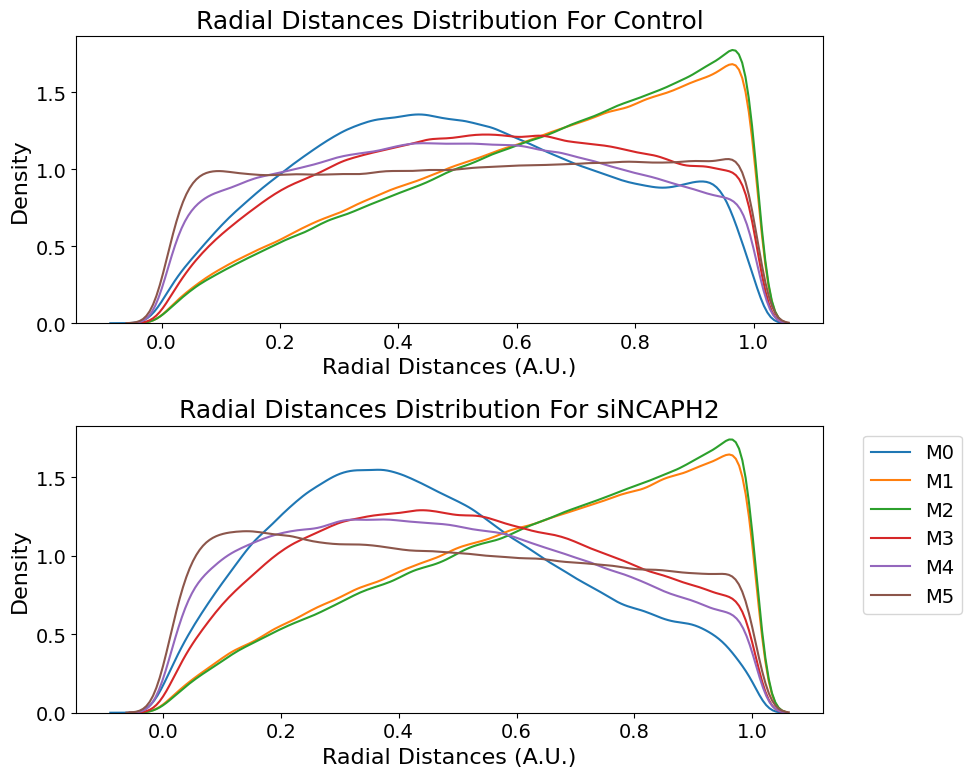

In [144]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to format labels
def format_label(text):
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to aggregate data by cell line and plot the distributions in a 4x2 grid
def plot_cell_line_distributions(cell_data, metric):
    gene_symbols = cell_data['gene_symbol'].unique()  # Get unique cell lines
    num_gene_symbols = len(gene_symbols)  # Number of unique cell lines
    
    # Create a 2x1 grid for plotting with the specified figure size
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Loop through each gene symbol and plot its distribution on a separate subplot
    for i, gene_symbol in enumerate(gene_symbols):
        ax = axes[i]
        for method in ['M0'] + [f'M{m}' for m in range(1, 6)]:
            # Get the data for the current gene symbol
            data_concat = np.concatenate(cell_data[cell_data['gene_symbol'] == gene_symbol][f'{method}_{metric}'].apply(np.hstack).values)
            
            # Plot the distribution using seaborn's kdeplot
            sns.kdeplot(data_concat, label=format_label(method), ax=ax)
        
        # Set title and labels for each subplot
        if gene_symbol=='siScrambled':
            gene_symbol1='Control'
        else: 
            gene_symbol1 = gene_symbol
        ax.set_title(f'{format_label(metric)} Distribution For {gene_symbol1}', fontsize=18)
        ax.set_xlabel(f'{format_label(metric)}' + ' (A.U.)', fontsize=16)
        ax.set_ylabel('Density', fontsize=16)
    
    # Add legend to the last subplot
    axes[-1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Example usage for radial distances
plot_cell_line_distributions(scr_ncaph2_df.loc[scr_ncaph2_df.spots_number < 47], 'radial_distances')


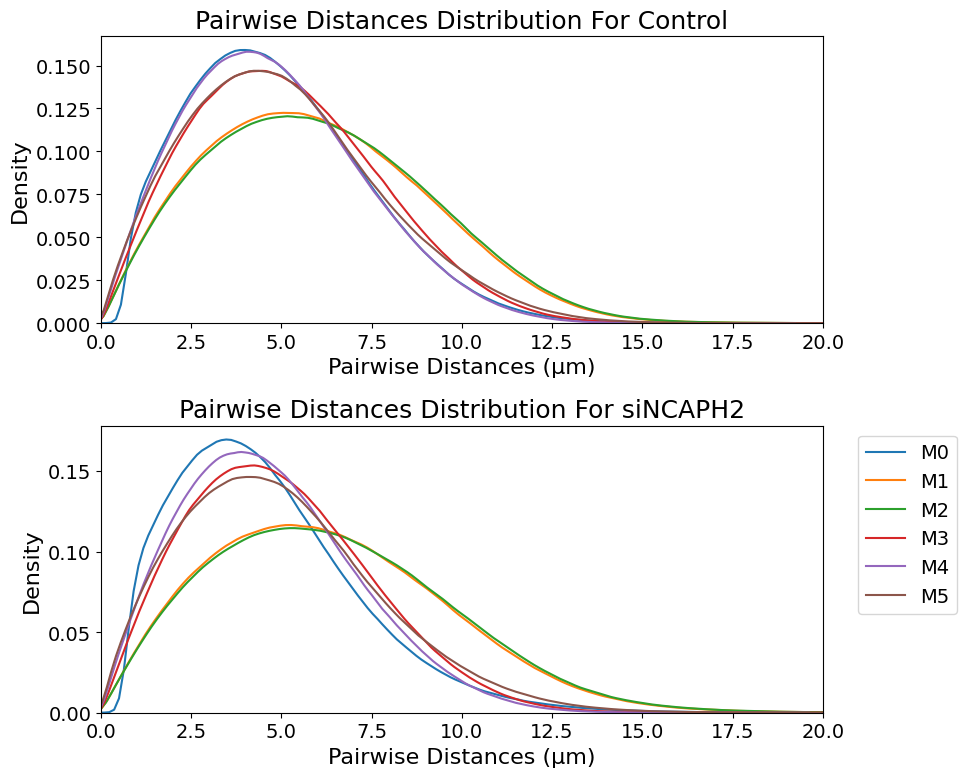

In [145]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to format labels
def format_label(text):
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to aggregate data by cell line and plot the distributions in a 4x2 grid
def plot_cell_line_distributions(cell_data, metric):
    gene_symbols = cell_data['gene_symbol'].unique()  # Get unique cell lines
    num_gene_symbols = len(gene_symbols)  # Number of unique cell lines
    
    # Create a 2x1 grid for plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Adjusted to 2 rows and 1 column
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Loop through each gene symbol and plot its distribution on a separate subplot
    for i, gene_symbol in enumerate(gene_symbols):
        ax = axes[i]
        for method in ['M0'] + [f'M{m}' for m in range(1, 6)]:
            # Get the data for the current gene symbol
            data_concat = np.concatenate(cell_data[cell_data['gene_symbol'] == gene_symbol][f'{method}_{metric}'].apply(np.hstack).values)
            
            # Plot the distribution using seaborn's kdeplot
            sns.kdeplot(data_concat, label=format_label(method), ax=ax)
        
        # Set title and labels for each subplot  
        if gene_symbol == 'siScrambled':
            gene_symbol1 = 'Control'
        else: 
            gene_symbol1 = gene_symbol
        ax.set_title(f'{format_label(metric)} Distribution For {gene_symbol1}', fontsize=18)
        ax.set_xlabel(f'{format_label(metric)}' + ' (\u03BCm)', fontsize=16)  # Updated to micrometers (µm)
        ax.set_ylabel('Density', fontsize=16)
        ax.set_xlim(0, 20)  # Set the x-axis limit

    # Add legend to the last subplot
    axes[-1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Example usage for pairwise distances
plot_cell_line_distributions(scr_ncaph2_df.loc[scr_ncaph2_df.spots_number < 47], 'pairwise_distances')


/tmp/ipykernel_126521/139345258.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_126521/139345258.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_126521/139345258.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_126521/139345258.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_126521/139345258.py:61: FutureWarning

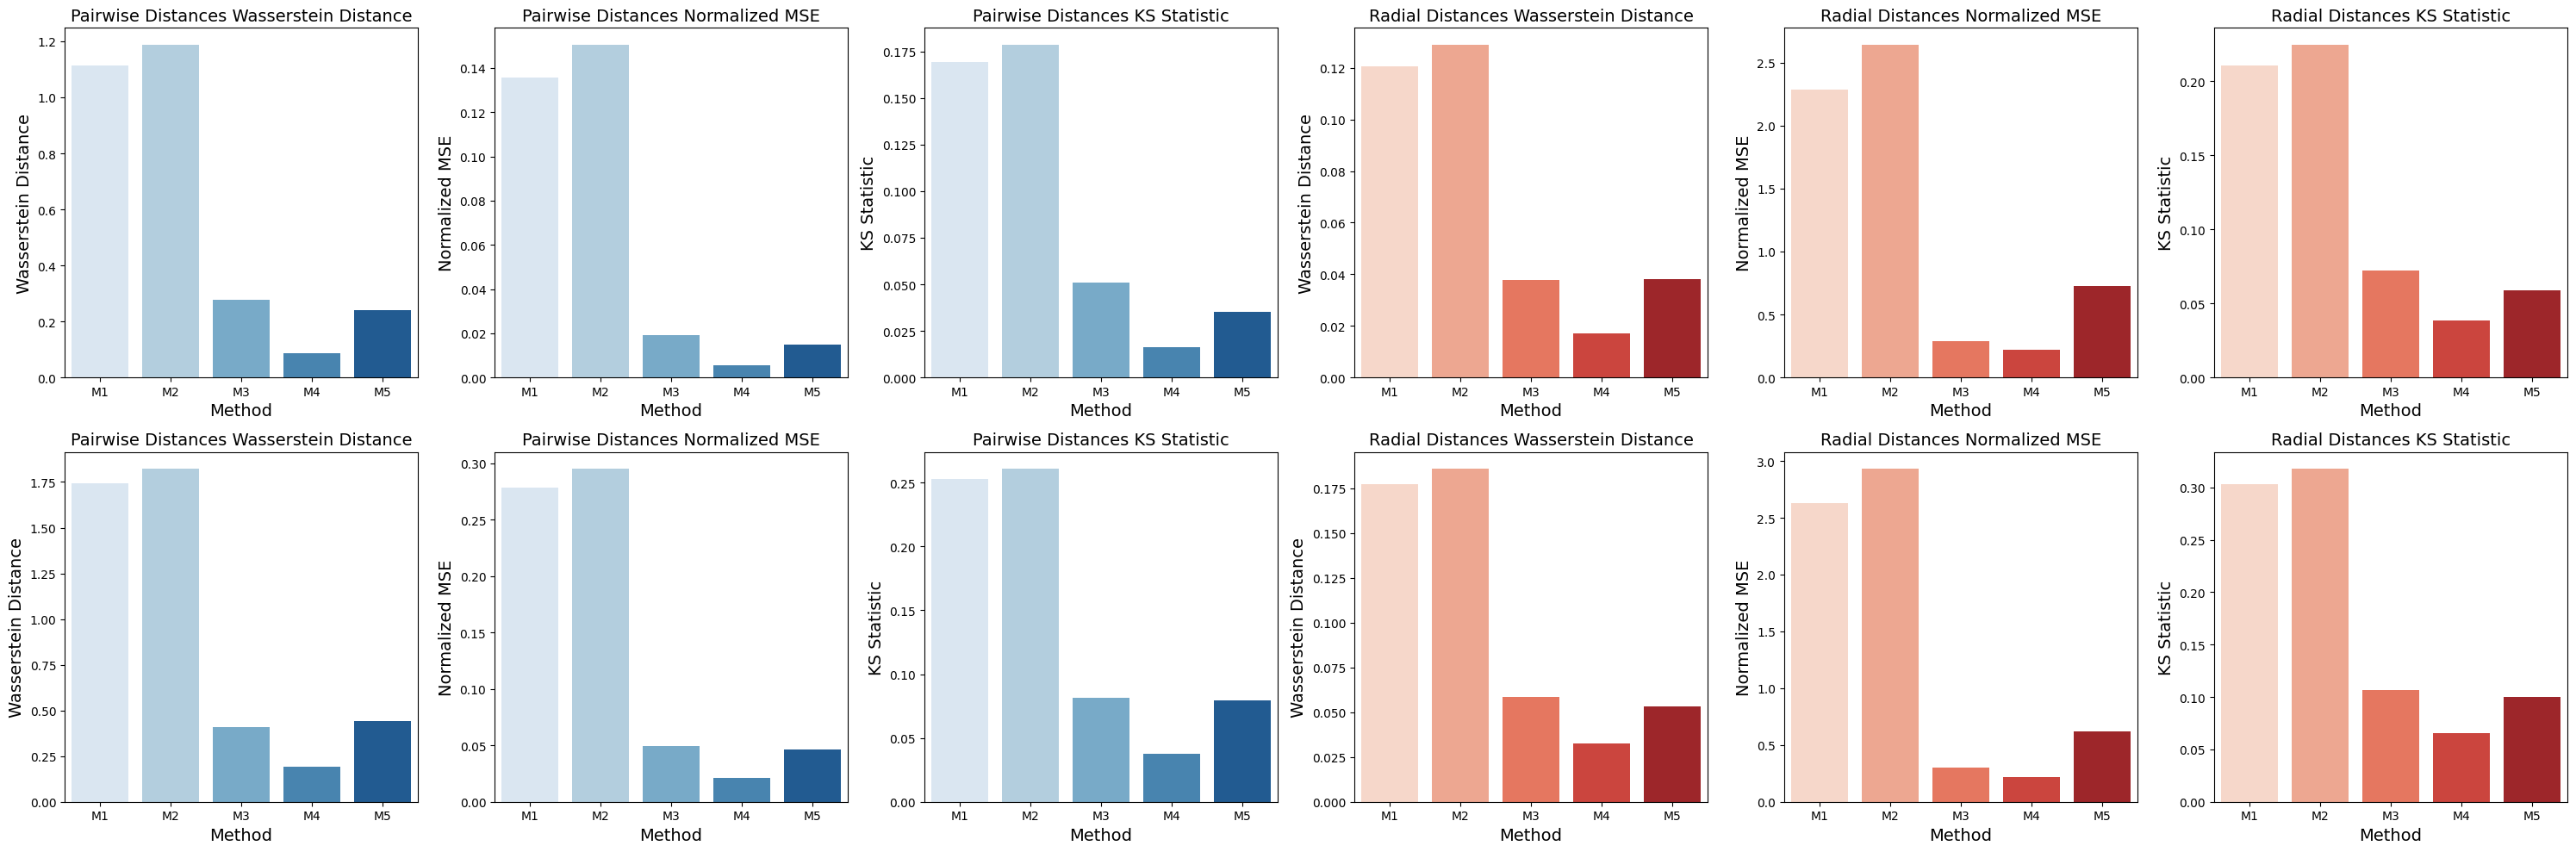

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.metrics import mean_squared_error
import numpy as np
metrics = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'MNND', 'dispersion_index']

def calculate_metrics(data, metric, methods=range(1, 6)):
    results = {"Wasserstein Distance": {}, "Normalized MSE": {}, "KS Statistic": {}}
    try:
        real_data = np.concatenate(data[f'M0_{metric}'].dropna().values)
    except:
        print(data[f'M0_{metric}'])
    real_data = real_data[~np.isnan(real_data)]

    for method in methods:
        synthetic_data = np.concatenate(data[f'M{method}_{metric}'].dropna().values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]

        if len(real_data) > len(synthetic_data):
            real_resampled = np.random.choice(real_data, len(synthetic_data), replace=False)
            synthetic_resampled = synthetic_data
        else:
            synthetic_resampled = np.random.choice(synthetic_data, len(real_data), replace=False)
            real_resampled = real_data

        if len(real_resampled) > 0 and len(synthetic_resampled) > 0:
            # Wasserstein Distance
            results["Wasserstein Distance"][f'M{method}'] = wasserstein_distance(real_resampled, synthetic_resampled)
            # Normalized MSE
            real_pdf, bins = np.histogram(real_resampled, bins=100, density=True)
            synthetic_pdf, _ = np.histogram(synthetic_resampled, bins=bins, density=True)
            real_pdf /= np.sum(real_pdf)
            synthetic_pdf /= np.sum(synthetic_pdf)
            mse = mean_squared_error(real_pdf, synthetic_pdf)
            results["Normalized MSE"][f'M{method}'] = mse / np.var(real_pdf)
            # KS Test
            ks_stat, _ = ks_2samp(real_resampled, synthetic_resampled)
            results["KS Statistic"][f'M{method}'] = ks_stat
        else:
            results["Wasserstein Distance"][f'M{method}'] = np.nan
            results["Normalized MSE"][f'M{method}'] = np.nan
            results["KS Statistic"][f'M{method}'] = np.nan

    return results

def plot_metrics(metrics_dict, gene_symbols):
    fig, axes = plt.subplots(2, 6, figsize=(30, 10))
    axes = axes.flatten()
    metric_types = ["Wasserstein Distance", "Normalized MSE", "KS Statistic"]
    colors = {"Pairwise Distances": "Blues", "Radial Distances": "Reds"}
    metrics = ['Pairwise Distances', 'Radial Distances']

    plot_idx = 0
    for gene_symbol in gene_symbols:
        for metric in metrics:
            for metric_type in metric_types:
            
                values = metrics_dict[metric][metric_type][gene_symbol]
                sns.barplot(
                    x=list(values.keys()),
                    y=list(values.values()),
                    ax=axes[plot_idx],
                    palette=colors[metric]
                )
                axes[plot_idx].set_title(f"{metric} {metric_type}", fontsize=14)
                axes[plot_idx].set_xlabel("Method", fontsize=14)
                axes[plot_idx].set_ylabel(metric_type, fontsize=14)
                # axes[plot_idx].set_xticklabels(fontsize=12)
                # axes[plot_idx].set_yticklabels(fontsize=12)
                plot_idx += 1

    # Adjust layout and remove extra subplots
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

def save_metrics_to_df(metrics_dict, gene_symbols):
    final_df = []
    for metric, metric_data in metrics_dict.items():
        for metric_type, gene_results in metric_data.items():
            for gene_symbol, method_results in gene_results.items():
                for method, value in method_results.items():
                    final_df.append({
                        "Metric": metric,
                        "Metric Type": metric_type,
                        "Gene Symbol": gene_symbol,
                        "Method": method,
                        "Value": value
                    })
    return pd.DataFrame(final_df)

# Example usage
metrics_dict = {
    "Pairwise Distances": {"Wasserstein Distance": {}, "Normalized MSE": {}, "KS Statistic": {}},
    "Radial Distances": {"Wasserstein Distance": {}, "Normalized MSE": {}, "KS Statistic": {}}
}
gene_symbols = ['Control', 'siNCAPH2']

for metric in metrics_dict.keys():
    for gene_symbol in gene_symbols:
        scr_ncaph2_df1=scr_ncaph2_df.loc[scr_ncaph2_df.spots_number < 47]
        gene_data = scr_ncaph2_df1[scr_ncaph2_df1['gene_symbol'] == gene_symbol]
        results = calculate_metrics(gene_data, metric.lower().replace(" ", "_"))
        for key in metrics_dict[metric]:
            metrics_dict[metric][key][gene_symbol] = results[key]

# Plot metrics
plot_metrics(metrics_dict, gene_symbols)

# Save to DataFrame and export
final_df = save_metrics_to_df(metrics_dict, gene_symbols)
final_df.to_csv("/data/krishnendu/ripley_paper/scr_ncaph2_results/metrics_summary_separated.csv", index=False)


In [32]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

metrics_to_analyze = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'MNND', 'dispersion_index']
methods = ['M1', 'M2', 'M3', 'M4', 'M5']

# Function to calculate metrics: Normalized MSE (based on histograms), KS Statistic, and Wasserstein Distance
def calculate_metrics(data1, data2):
    # Check if data arrays are non-empty
    if len(data1) == 0 or len(data2) == 0:
        return np.nan, np.nan, np.nan  # Return NaN for all metrics if data is invalid

    # Compute histograms for both datasets
    bins = np.histogram_bin_edges(np.concatenate((data1, data2)), bins=100)
    hist1, _ = np.histogram(data1, bins=bins, density=True)
    hist2, _ = np.histogram(data2, bins=bins, density=True)
    
    # Normalize histograms to sum to 1
    sum_hist1 = np.sum(hist1)
    sum_hist2 = np.sum(hist2)
    
    if sum_hist1 == 0 or sum_hist2 == 0:
        return np.nan, np.nan, np.nan  # Return NaN if normalization is not possible

    hist1 /= sum_hist1
    hist2 /= sum_hist2
    
    # Calculate Mean Squared Error (MSE) between the PDFs
    mse_pdf = mean_squared_error(hist1, hist2)
    var_hist1 = np.var(hist1)
    if var_hist1 == 0:
        normalized_mse_pdf = np.nan  # Handle edge case where variance is zero
    else:
        normalized_mse_pdf = mse_pdf / var_hist1  # Normalize by the variance of the real PDF
    
    # Calculate KS Statistic
    ks_stat, _ = ks_2samp(data1, data2)
    
    # Calculate Wasserstein Distance
    w_distance = wasserstein_distance(data1, data2)
    
    return normalized_mse_pdf, ks_stat, w_distance

# Prepare the results dictionary
distance_results = []

for metric in metrics_to_analyze:
    for method in methods:
        real_data = scr_ncaph2_df.loc[(scr_ncaph2_df.spots_number < 47) & (scr_ncaph2_df.gene_symbol == 'siNCAPH2')][f'M0_{metric}'].dropna()
        method_data = scr_ncaph2_df.loc[(scr_ncaph2_df.spots_number < 47) & (scr_ncaph2_df.gene_symbol == 'siNCAPH2')][f'{method}_{metric}'].dropna()
        
        # Align real and method data to ensure equal sample size
        real_data, method_data = real_data.align(method_data, join='inner')
        
        # Calculate Normalized MSE (based on PDFs), KS Statistic, and Wasserstein Distance
        normalized_mse_pdf, ks_stat, w_distance = calculate_metrics(real_data.values, method_data.values)
        distance_results.append({
            'Metric': metric,
            'Method': method,
            'Normalized MSE': normalized_mse_pdf,
            'KS Statistic': ks_stat,
            'Wasserstein Distance': w_distance
        })

# Display results
distance_results_df = pd.DataFrame(distance_results)
from IPython.display import display
display(distance_results_df)


,Metric,Method,Normalized MSE,KS Statistic,Wasserstein Distance
0,ripley_k_score,M1,21.871770,0.835406,37.362661
1,ripley_k_score,M2,23.122076,0.848675,37.822302
2,ripley_k_score,M3,1.414285,0.357221,17.208830
3,ripley_k_score,M4,0.335501,0.176062,9.454980
4,ripley_k_score,M5,1.058348,0.341272,14.667028
5,assortativity,M1,0.009506,0.016433,0.000709
6,assortativity,M2,0.010760,0.016829,0.000715
7,assortativity,M3,0.010355,0.015906,0.000604
8,assortativity,M4,0.008938,0.014939,0.000554
9,assortativity,M5,0.002368,0.010413,0.000330


In [88]:
distance_results_df.loc[distance_results_df['Metric']=='mean_nearest_neighbor_distance', 'Metric']="MNND"

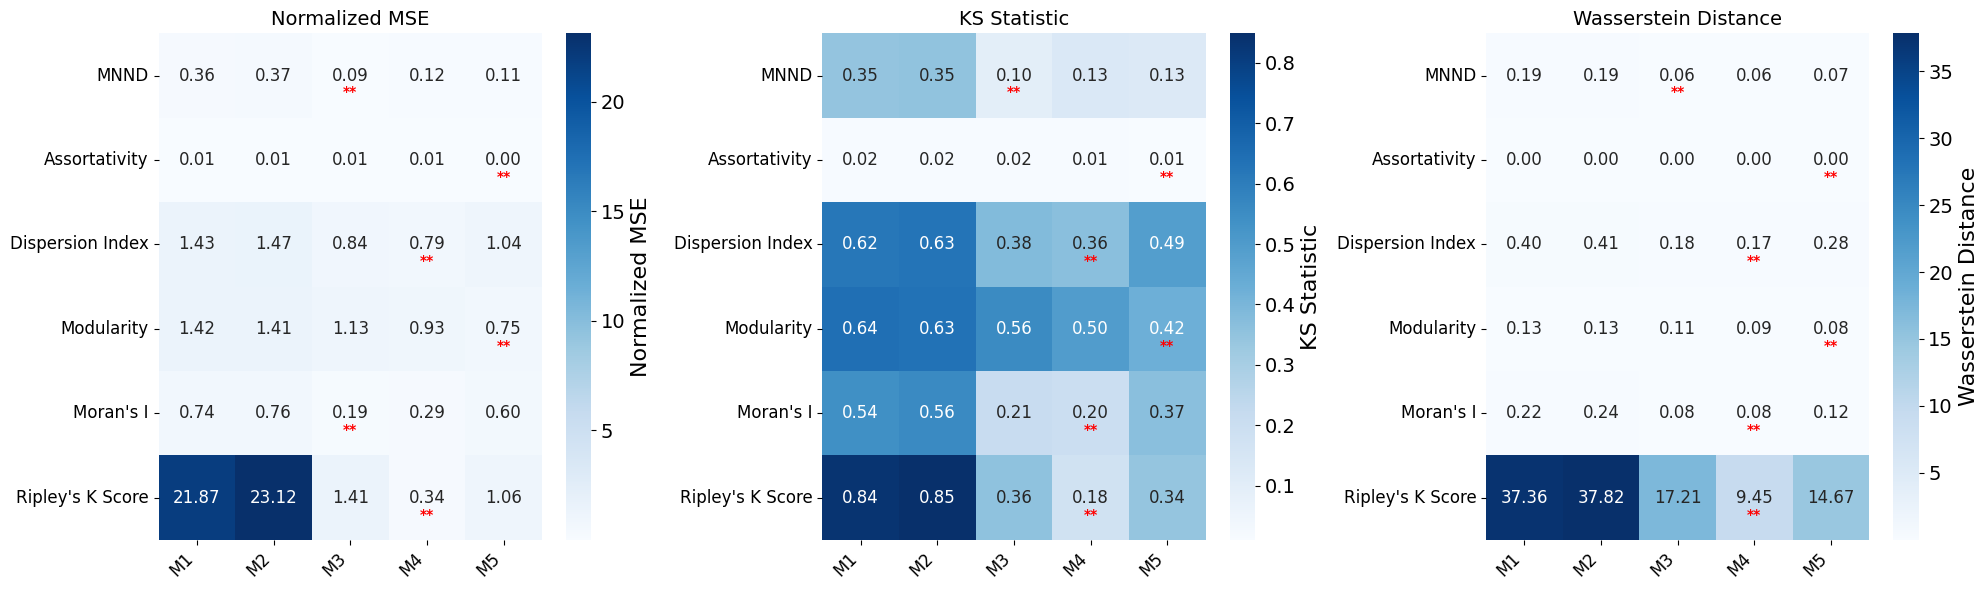

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to format labels
def format_label(text):
    if (text=='MNND') or (text=='Normalized MSE') or (text=='KS Statistic'):
        return text
    if  (text=="ripley_k_score"):
        return "Ripley's K Score"
    if  (text=="morans_i"):
        return "Moran's I"
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to create heatmaps and mark the lowest values for each metric
def plot_heatmap_with_min_highlight(ax, pivot_df, title, cbar_label):
    # Set annotation font size using annot_kws
    sns.heatmap(
        pivot_df,
        annot=True,
        cmap='Blues',
        cbar_kws={'label': format_label(cbar_label)},
        fmt=".2f",
        ax=ax,
        annot_kws={'size': 12}
    )
    
    # Highlight the minimum value in each row (for each metric)
    for i in range(pivot_df.shape[0]):
        min_value_idx = pivot_df.iloc[i].idxmin()
        min_value = pivot_df.iloc[i].min()
        ax.text(pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.7, '**', 
                color='red', ha='center', va='center', fontweight='bold', fontsize=10)

    # Remove x and y labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set tick label size to 8 and format tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels([format_label(label) for label in pivot_df.columns], rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels([format_label(label) for label in pivot_df.index], rotation=0, fontsize=12)
    
    # Update cbar label font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)  # Adjust tick font size
    cbar.set_label(format_label(cbar_label), fontsize=16)  # Adjust label font size
    
    # Set title
    ax.set_title(title, fontsize=14)

# Example usage: Pivot the dataframe for heatmap plotting
mse_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Normalized MSE')
ks_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='KS Statistic')
wass_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Wasserstein Distance')

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot heatmap for Normalized MSE
plot_heatmap_with_min_highlight(axes[0], mse_pivot, 'Normalized MSE', 'Normalized MSE')

# Plot heatmap for KS Statistic
plot_heatmap_with_min_highlight(axes[1], ks_pivot, 'KS Statistic', 'KS Statistic')

# Plot heatmap for Wasserstein Distance
plot_heatmap_with_min_highlight(axes[2], wass_pivot, 'Wasserstein Distance', 'Wasserstein Distance')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [36]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

metrics_to_analyze = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'MNND', 'dispersion_index']
methods = ['M1', 'M2', 'M3', 'M4', 'M5']

# Function to compute the empirical CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Function to calculate Normalized MSE (based on CDF), KS Statistic, and Wasserstein Distance
def calculate_metrics(data1, data2):
    # Compute the CDFs for both datasets
    x1, cdf1 = compute_cdf(data1)
    x2, cdf2 = compute_cdf(data2)
    
    # Interpolate both CDFs to align them on a common set of points
    min_x = min(np.min(x1), np.min(x2))
    max_x = max(np.max(x1), np.max(x2))
    common_points = np.linspace(min_x, max_x, 100)  # 100 common points for interpolation
    
    interp_cdf1 = interp1d(x1, cdf1, bounds_error=False, fill_value=(0, 1))(common_points)
    interp_cdf2 = interp1d(x2, cdf2, bounds_error=False, fill_value=(0, 1))(common_points)
    
    # Calculate Mean Squared Error (MSE) between the CDFs
    mse_cdf = mean_squared_error(interp_cdf1, interp_cdf2)
    normalized_mse_cdf = mse_cdf / np.var(interp_cdf1)  # Normalize by the variance of the real CDF
    
    # Calculate KS Statistic
    ks_stat, _ = ks_2samp(data1, data2)
    
    # Calculate Wasserstein Distance
    w_distance = wasserstein_distance(data1, data2)
    
    return normalized_mse_cdf, ks_stat, w_distance

# Prepare the results dictionary
distance_results = []

for metric in metrics_to_analyze:
    for method in methods:
        real_data = scr_ncaph2_df.loc[(scr_ncaph2_df.spots_number<47)&(scr_ncaph2_df.gene_symbol=='Control')][f'M0_{metric}'].dropna()
        method_data = scr_ncaph2_df.loc[(scr_ncaph2_df.spots_number<47)&(scr_ncaph2_df.gene_symbol=='Control')][f'{method}_{metric}'].dropna()
        
        # Align real and method data to ensure equal sample size
        real_data, method_data = real_data.align(method_data, join='inner')
        
        # Calculate Normalized MSE (based on CDF), KS Statistic, and Wasserstein Distance
        normalized_mse_cdf, ks_stat, w_distance = calculate_metrics(real_data.values, method_data.values)
        distance_results.append({
            'Metric': metric,
            'Method': method,
            'Normalized MSE': normalized_mse_cdf,
            'KS Statistic': ks_stat,
            'Wasserstein Distance': w_distance
        })

# Display results
distance_results_df = pd.DataFrame(distance_results)
distance_results_df.loc[distance_results_df['Metric']=='mean_nearest_neighbor_distance', 'Metric']="MNND"
from IPython.display import display
display(distance_results_df)


,Metric,Method,Normalized MSE,KS Statistic,Wasserstein Distance
0,ripley_k_score,M1,0.824837,0.533878,13.857864
1,ripley_k_score,M2,0.866526,0.546210,14.135512
2,ripley_k_score,M3,0.051913,0.145680,3.233390
3,ripley_k_score,M4,0.141350,0.192840,6.985508
4,ripley_k_score,M5,0.015591,0.116994,1.680121
5,assortativity,M1,0.000076,0.014541,0.000282
6,assortativity,M2,0.000076,0.012685,0.000287
7,assortativity,M3,0.000065,0.013790,0.000261
8,assortativity,M4,0.000047,0.011669,0.000253
9,assortativity,M5,0.000015,0.006807,0.000189


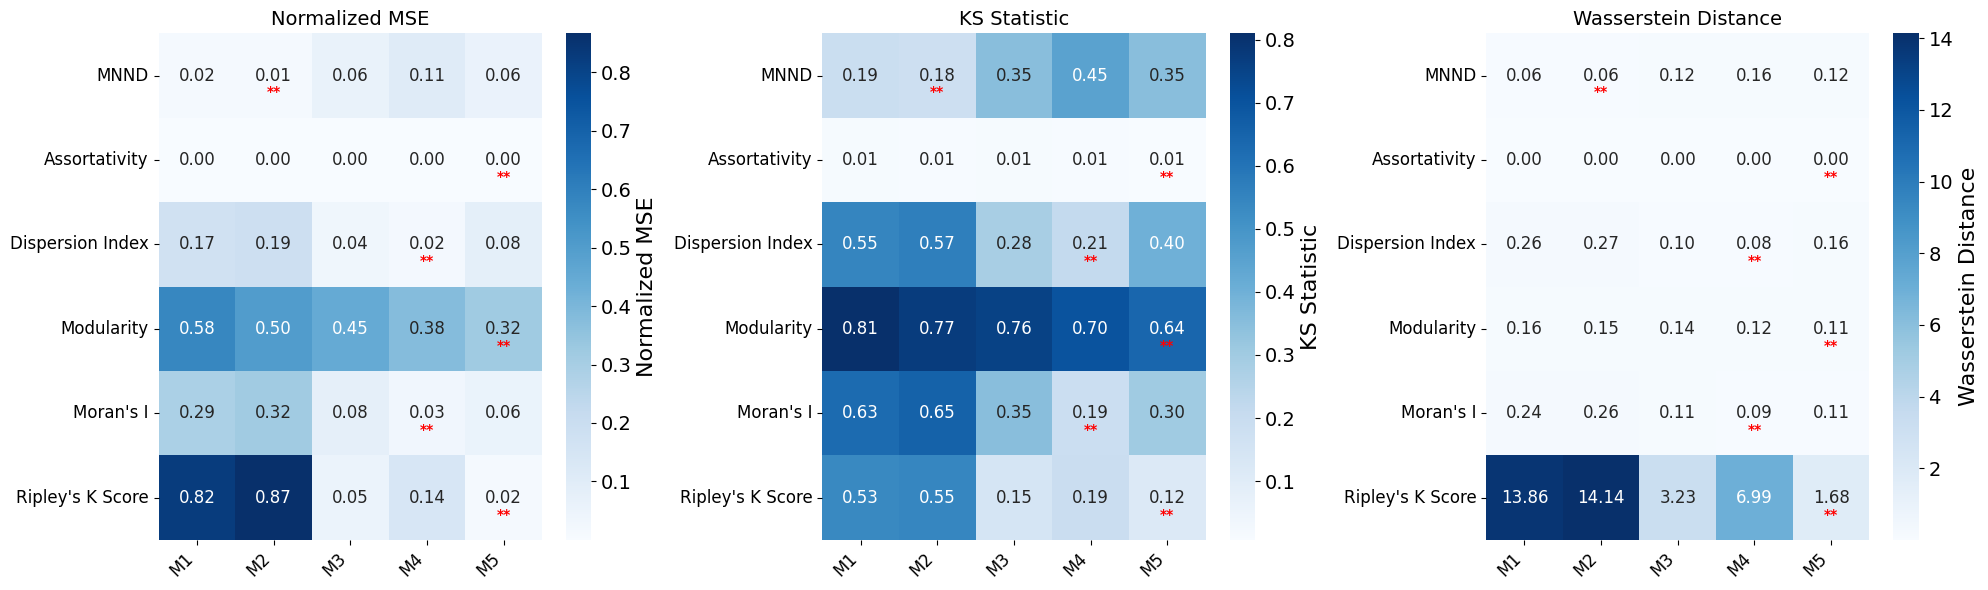

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to format labels
def format_label(text):
    if (text=='MNND') or (text=='Normalized MSE') or (text=='KS Statistic'):
        return text
    if  (text=="ripley_k_score"):
        return "Ripley's K Score"
    if  (text=="morans_i"):
        return "Moran's I"
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to create heatmaps and mark the lowest values for each metric
def plot_heatmap_with_min_highlight(ax, pivot_df, title, cbar_label):
    # Set annotation font size using annot_kws
    sns.heatmap(
        pivot_df,
        annot=True,
        cmap='Blues',
        cbar_kws={'label': format_label(cbar_label)},
        fmt=".2f",
        ax=ax,
        annot_kws={'size': 12}
    )
    
    # Highlight the minimum value in each row (for each metric)
    for i in range(pivot_df.shape[0]):
        min_value_idx = pivot_df.iloc[i].idxmin()
        min_value = pivot_df.iloc[i].min()
        ax.text(pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.7, '**', 
                color='red', ha='center', va='center', fontweight='bold', fontsize=10)

    # Remove x and y labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set tick label size to 8 and format tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels([format_label(label) for label in pivot_df.columns], rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels([format_label(label) for label in pivot_df.index], rotation=0, fontsize=12)
    
    # Update cbar label font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)  # Adjust tick font size
    cbar.set_label(format_label(cbar_label), fontsize=16)  # Adjust label font size
    
    # Set title
    ax.set_title(title, fontsize=14)

# Example usage: Pivot the dataframe for heatmap plotting
mse_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Normalized MSE')
ks_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='KS Statistic')
wass_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Wasserstein Distance')

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot heatmap for Normalized MSE
plot_heatmap_with_min_highlight(axes[0], mse_pivot, 'Normalized MSE', 'Normalized MSE')

# Plot heatmap for KS Statistic
plot_heatmap_with_min_highlight(axes[1], ks_pivot, 'KS Statistic', 'KS Statistic')

# Plot heatmap for Wasserstein Distance
plot_heatmap_with_min_highlight(axes[2], wass_pivot, 'Wasserstein Distance', 'Wasserstein Distance')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
